# Setup: install libs and import

In [ ]:
# Cell 1 - Setup: install libs and import
!pip install -q pandas openpyxl scikit-learn matplotlib seaborn joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Setup done.")


Setup done.


# Load dataset (upload in Colab or use existing path)

In [ ]:
# Cell 2 - Load dataset (upload in Colab or use existing path)
from google.colab import files

print("If first time, uncomment files.upload() below to upload your Excel file.")
# uploaded = files.upload()  # <-- uncomment in Colab to upload interactively

# Default dataset path (adjust if different)
DATA_PATH = "/content/final_commodity_price_dataset (1).xlsx"
if not os.path.exists(DATA_PATH):
    # try to auto-find an excel file in working dir
    matches = list(Path(".").glob("*.xlsx")) + list(Path(".").glob("*.xls"))
    if matches:
        DATA_PATH = str(matches[0])
    else:
        raise FileNotFoundError("No dataset found. Upload dataset via files.upload() or place it at /content/final_commodity_price_dataset.xlsx")

df = pd.read_excel(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head(5)


If first time, uncomment files.upload() below to upload your Excel file.
Loaded: /content/final_commodity_price_dataset (1).xlsx
Shape: (3285, 10)


,Date Time,Market,Commodity,Variation,Unit,Min Price,Max Price,Weather,Seasonal Harvest,Day_of_Week
0,2024-09-23,Dhaka Mohanagar,Chal,Najir,kg,64,80,Rainy,Yes,Monday
1,2024-09-23,Dhaka Mohanagar,Chal,BR-28,kg,55,60,Cloudy,Yes,Monday
2,2024-09-23,Dhaka Mohanagar,Chal,Shorna,kg,52,55,Cloudy,Yes,Monday
3,2024-09-23,Dhaka Mohanagar,Musuri Dal,Boro Dana,kg,105,110,Cloudy,Yes,Monday
4,2024-09-23,Dhaka Mohanagar,Musuri Dal,Choto Dana,kg,130,135,Rainy,Yes,Monday


# EDA

Columns: ['Date Time', 'Market', 'Commodity', 'Variation', 'Unit', 'Min Price', 'Max Price', 'Weather', 'Seasonal Harvest', 'Day_of_Week']

Missing values per column:
 Date Time           0
Market              0
Commodity           0
Variation           0
Unit                0
Min Price           0
Max Price           0
Weather             0
Seasonal Harvest    0
Day_of_Week         0
dtype: int64

Data types:
 Date Time           datetime64[ns]
Market                      object
Commodity                   object
Variation                   object
Unit                        object
Min Price                    int64
Max Price                    int64
Weather                     object
Seasonal Harvest            object
Day_of_Week                 object
dtype: object


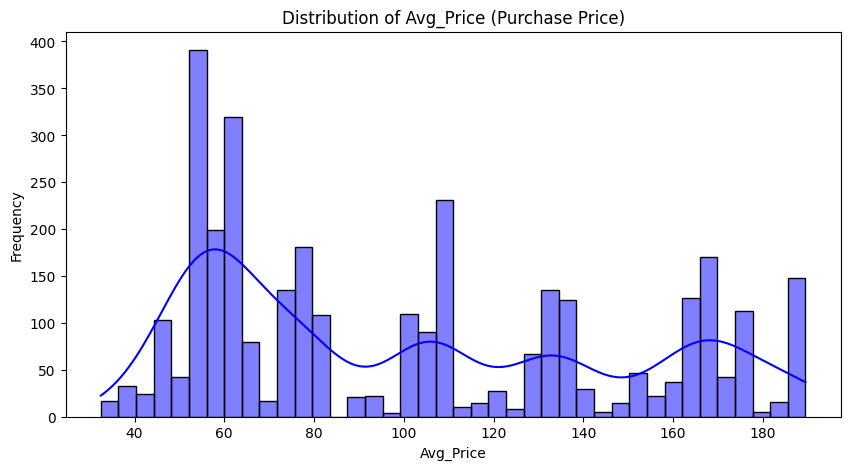

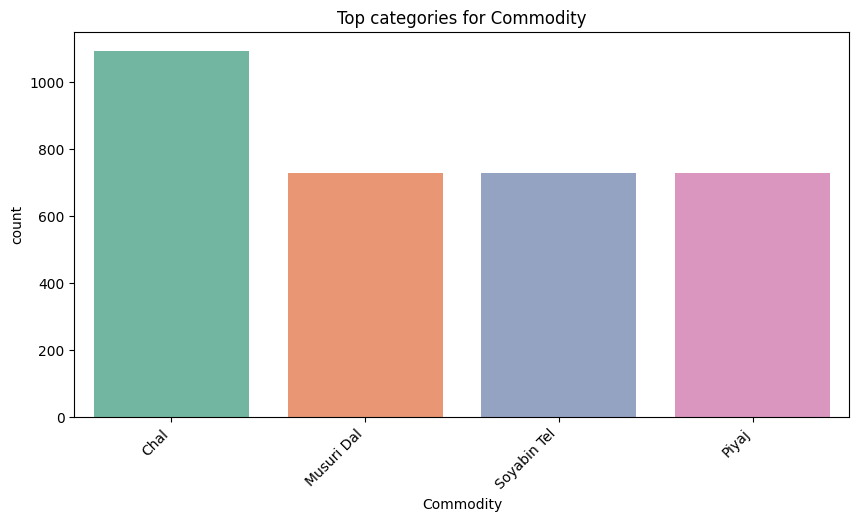

In [ ]:
# Cell 3 - Visual EDA
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

# Create Avg_Price if Max/Min available
if "Max Price" in df.columns and "Min Price" in df.columns:
    df["Avg_Price"] = df[["Max Price", "Min Price"]].mean(axis=1)

# --- Numeric EDA ---
plt.figure(figsize=(10,5))
sns.histplot(df["Avg_Price"].dropna(), bins=40, kde=True, color="blue")
plt.title("Distribution of Avg_Price (Purchase Price)")
plt.xlabel("Avg_Price")
plt.ylabel("Frequency")
plt.show()

# --- Categorical EDA ---
cat_cols = ["Commodity"]
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(10,5))
        order = df[col].value_counts().head(15).index  # top 15
        sns.countplot(data=df, x=col, order=order, palette="Set2")
        plt.title(f"Top categories for {col}")
        plt.xticks(rotation=45, ha="right")
        plt.show()


# cleaning & features

In [ ]:
# Cell 4 - Cleaning / Feature prep

# Ensure Date Time parsed if exists (we won't use Month in modeling, but parse for potential feature engineering)
if "Date Time" in df.columns:
    df["Date Time"] = pd.to_datetime(df["Date Time"], errors="coerce")
    df["Year"] = df["Date Time"].dt.year
    df["Month"] = df["Date Time"].dt.month
    df["Day"] = df["Date Time"].dt.day

# Ensure Avg_Price exists (if not, try to derive from available price columns)
if "Avg_Price" not in df.columns:
    if "Price" in df.columns:
        df["Avg_Price"] = df["Price"].astype(float)
    elif {"Min Price", "Max Price"}.issubset(df.columns):
        df["Avg_Price"] = (df["Min Price"].astype(float) + df["Max Price"].astype(float)) / 2
    else:
        raise KeyError(
            "Avg_Price not found and could not be derived. "
            "Please provide Avg_Price, Price, or Min/Max Price columns."
        )

# Fill missing Avg_Price with group median by commodity if any
df["Avg_Price"] = df["Avg_Price"].fillna(
    df.groupby("Commodity")["Avg_Price"].transform("median")
)

# Drop rows that still lack required core values
required_for_model = [
    "Commodity", "Variation", "Unit", "Avg_Price",
    "Weather", "Seasonal Harvest", "Day_of_Week"
]
df = df.dropna(subset=["Commodity", "Avg_Price"])

print("After initial cleaning shape:", df.shape)


After initial cleaning shape: (3285, 14)


# create synthetic 'syndicate' label (IsolationForest)

In [ ]:
# Cell 5 - Create synthetic 'syndicate' label via anomaly detection
# Rationale: label rows with anomalous price behavior as potential 'syndicate' events.

# Compute group medians for commodity to get price_ratio
df["commodity_median"] = df.groupby("Commodity")["Avg_Price"].transform("median")
df["price_ratio"] = df["Avg_Price"] / (df["commodity_median"] + 1e-9)

# Prepare features for IsolationForest
iso_features = df[["price_ratio", "Avg_Price"]].fillna(0)

iso = IsolationForest(n_estimators=200, contamination='auto', random_state=RANDOM_STATE)
iso.fit(iso_features)
df["anomaly_score"] = iso.decision_function(iso_features)
df["anomaly_flag"] = iso.predict(iso_features)  # -1 anomaly, 1 normal
df["syndicate"] = (df["anomaly_flag"] == -1).astype(int)

print("Syndicate label distribution:\n", df["syndicate"].value_counts())


Syndicate label distribution:
 syndicate
0    2445
1     840
Name: count, dtype: int64


# restrict to final features and split

In [ ]:
# Cell 6 - Use exactly the features your Flask UI will provide
FEATURE_COLUMNS = ["Commodity", "Variation", "Unit", "Avg_Price", "Weather", "Seasonal Harvest", "Day_of_Week"]
for c in FEATURE_COLUMNS:
    if c not in df.columns:
        raise KeyError(f"Required feature '{c}' not found in dataset. Please ensure column exists.")

X = df[FEATURE_COLUMNS].copy()
y = df["syndicate"].copy()

print("Feature sample:")
display(X.head())

print("Label balance:\n", y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print("Train/test sizes:", X_train.shape[0], X_test.shape[0])


Feature sample:


,Commodity,Variation,Unit,Avg_Price,Weather,Seasonal Harvest,Day_of_Week
0,Chal,Najir,kg,72.0,Rainy,Yes,Monday
1,Chal,BR-28,kg,57.5,Cloudy,Yes,Monday
2,Chal,Shorna,kg,53.5,Cloudy,Yes,Monday
3,Musuri Dal,Boro Dana,kg,107.5,Cloudy,Yes,Monday
4,Musuri Dal,Choto Dana,kg,132.5,Rainy,Yes,Monday


Label balance:
 syndicate
0    2445
1     840
Name: count, dtype: int64
Train/test sizes: 2628 657


# preprocessing pipeline (OHE for categoricals + scaler for numeric)

In [ ]:
# Cell 7 - Preprocessing (fixed for sklearn >=1.2)
numeric_features = ["Avg_Price"]
categorical_features = [c for c in FEATURE_COLUMNS if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop', sparse_threshold=0)

# Fit preprocessor
preprocessor.fit(X_train)
Xt_sample = preprocessor.transform(X_train)
print("Transformed train shape:", Xt_sample.shape)


Numeric: ['Avg_Price']
Categorical: ['Commodity', 'Variation', 'Unit', 'Weather', 'Seasonal Harvest', 'Day_of_Week']
Transformed train shape: (2628, 28)


# Define models

In [ ]:
# Cell 8 - Define models and pipelines
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}

pipelines = {}
for name, clf in models.items():
    pipelines[name] = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])
print("Prepared pipelines:", list(pipelines.keys()))


Prepared pipelines: ['LogisticRegression', 'RandomForest', 'ExtraTrees', 'AdaBoost', 'SVC', 'KNN', 'NaiveBayes']


# train all models and collect metrics

In [ ]:
# Cell 9 - Train & evaluate models
results = []
fitted = {}

for name, pipe in pipelines.items():
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"{name}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, roc_auc={'{:.4f}'.format(roc) if not np.isnan(roc) else 'N/A'}")
    fitted[name] = pipe
    results.append({"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc})

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df)



Training LogisticRegression ...
LogisticRegression: acc=0.7778, prec=0.5753, rec=0.5000, f1=0.5350, roc_auc=0.8522

Training RandomForest ...
RandomForest: acc=0.9833, prec=0.9876, rec=0.9464, f1=0.9666, roc_auc=0.9973

Training ExtraTrees ...
ExtraTrees: acc=0.9391, prec=0.9267, rec=0.8274, f1=0.8742, roc_auc=0.9909

Training AdaBoost ...
AdaBoost: acc=0.9939, prec=1.0000, rec=0.9762, f1=0.9880, roc_auc=0.9996

Training SVC ...
SVC: acc=0.8265, prec=0.7328, rec=0.5060, f1=0.5986, roc_auc=0.8665

Training KNN ...
KNN: acc=0.8767, prec=0.9065, rec=0.5774, f1=0.7055, roc_auc=0.9040

Training NaiveBayes ...
NaiveBayes: acc=0.7458, prec=0.5017, rec=0.8929, f1=0.6424, roc_auc=0.8511


,model,accuracy,precision,recall,f1,roc_auc
0,AdaBoost,0.993912,1.000000,0.976190,0.987952,0.999635
1,RandomForest,0.983257,0.987578,0.946429,0.966565,0.997304
2,ExtraTrees,0.939117,0.926667,0.827381,0.874214,0.990925
3,KNN,0.876712,0.906542,0.577381,0.705455,0.904007
4,NaiveBayes,0.745814,0.501672,0.892857,0.642398,0.851069
5,SVC,0.826484,0.732759,0.505952,0.598592,0.866504
6,LogisticRegression,0.777778,0.575342,0.500000,0.535032,0.852164


# ROC curves & confusion matrices

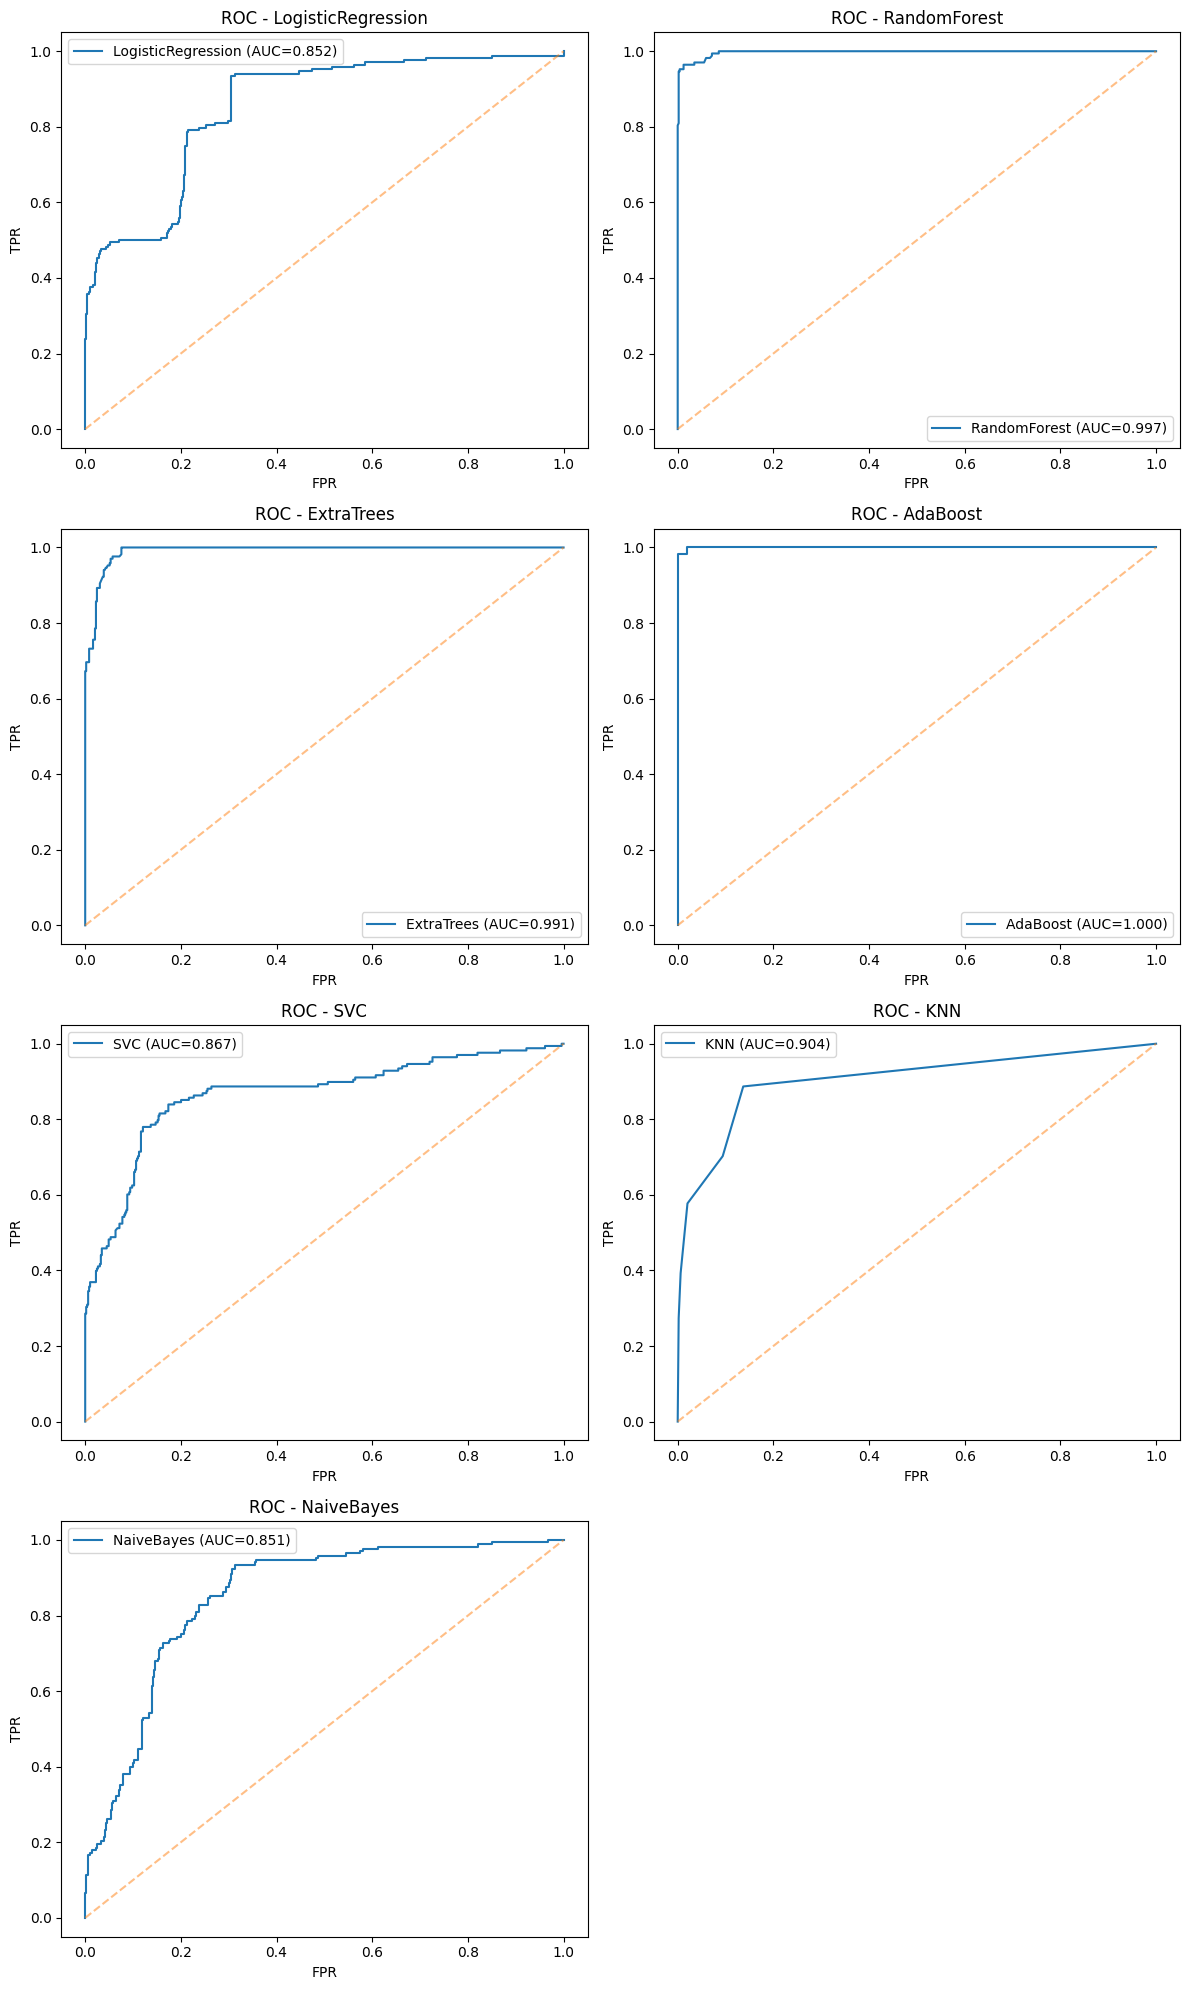

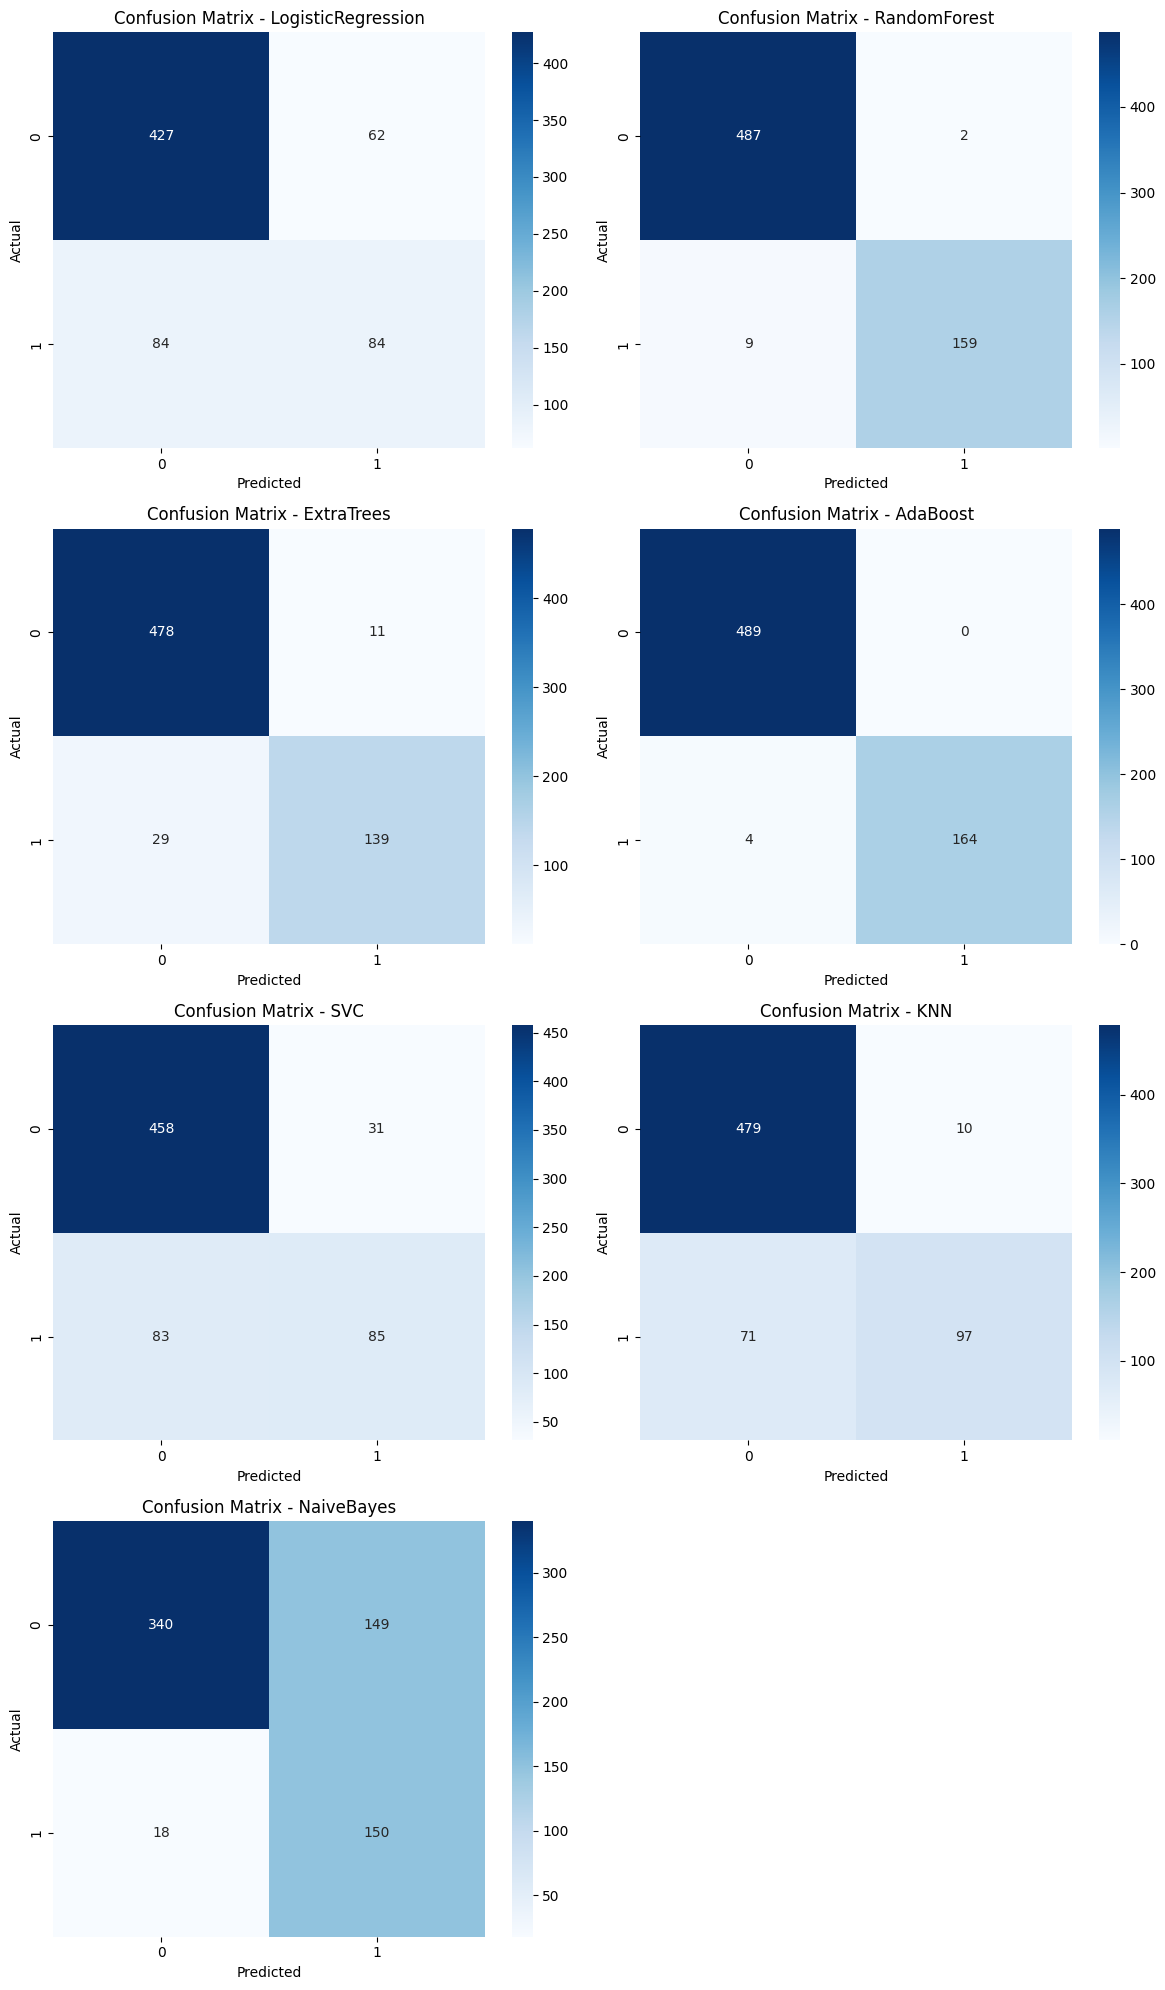

In [ ]:
# Cell 10 - ROC curves and confusion matrices
import math
names = list(fitted.keys())
n = len(names)
cols = 2
rows = math.ceil(n/cols)

plt.figure(figsize=(12, 5*rows))
i = 1
for name in names:
    pipe = fitted[name]
    plt.subplot(rows, cols, i)
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,y_proba):.3f})")
        plt.plot([0,1],[0,1], '--', alpha=0.5)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {name}"); plt.legend()
    else:
        plt.text(0.1, 0.5, f"No probability for {name}", fontsize=12)
    i += 1
plt.tight_layout()
plt.show()

# Confusion matrices
plt.figure(figsize=(12, 5*rows))
i = 1
for name in names:
    y_pred = fitted[name].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(rows, cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    i += 1
plt.tight_layout()
plt.show()


# classification reports & importances for tree models

In [ ]:
# Cell 11 - Reports & feature importances (tree-based)
for name in names:
    print("\n" + "="*60)
    print("Model:", name)
    pipe = fitted[name]
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))



Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       489
           1       0.58      0.50      0.54       168

    accuracy                           0.78       657
   macro avg       0.71      0.69      0.69       657
weighted avg       0.77      0.78      0.77       657


Model: RandomForest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       489
           1       0.99      0.95      0.97       168

    accuracy                           0.98       657
   macro avg       0.98      0.97      0.98       657
weighted avg       0.98      0.98      0.98       657


Model: ExtraTrees
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       489
           1       0.93      0.83      0.87       168

    accuracy                           0.94       657
   macro avg       0.93      0.90      0.92       657
weighte

# compare and pick best model

In [ ]:
# Cell 12 - Compare models and pick best by F1
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df)
best_model_name = results_df.loc[0, "model"]
print("Selected best model by F1:", best_model_name)
best_pipeline = fitted[best_model_name]


,model,accuracy,precision,recall,f1,roc_auc
0,AdaBoost,0.993912,1.000000,0.976190,0.987952,0.999635
1,RandomForest,0.983257,0.987578,0.946429,0.966565,0.997304
2,ExtraTrees,0.939117,0.926667,0.827381,0.874214,0.990925
3,KNN,0.876712,0.906542,0.577381,0.705455,0.904007
4,NaiveBayes,0.745814,0.501672,0.892857,0.642398,0.851069
5,SVC,0.826484,0.732759,0.505952,0.598592,0.866504
6,LogisticRegression,0.777778,0.575342,0.500000,0.535032,0.852164


Selected best model by F1: AdaBoost


# Save the best pipeline & artifacts

In [ ]:
# Cell 14 - Save pipeline and artifacts
os.makedirs("artifacts", exist_ok=True)
MODEL_PATH = "artifacts/best_pipeline.joblib"
joblib.dump(best_pipeline, MODEL_PATH)
print("Saved best pipeline to:", MODEL_PATH)

# Also save preprocessor (optional)
PREPROCESSOR_PATH = "artifacts/preprocessor.joblib"
joblib.dump(preprocessor, PREPROCESSOR_PATH)
print("Saved preprocessor to:", PREPROCESSOR_PATH)

# Save comparison table
results_df.to_csv("artifacts/model_comparison.csv", index=False)
print("Saved model comparison to artifacts/model_comparison.csv")

# Cell 15 - Download artifacts
from google.colab import files
files.download("artifacts/best_pipeline.joblib")
files.download("artifacts/preprocessor.joblib")
files.download("artifacts/model_comparison.csv")


Saved best pipeline to: artifacts/best_pipeline.joblib
Saved preprocessor to: artifacts/preprocessor.joblib
Saved model comparison to artifacts/model_comparison.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>